In [1]:
!unzip chess_dataset.zip

Archive:  chess_dataset.zip
   creating: chess_dataset/train/
   creating: chess_dataset/train/black_bishop/
  inflating: chess_dataset/train/black_bishop/35ae6c85de97571075b4ab0880faf27d_black_bishop_g7.jpg  
  inflating: chess_dataset/train/black_bishop/35ae6c85de97571075b4ab0880faf27d_black_bishop_g8.jpg  
  inflating: chess_dataset/train/black_bishop/4564961c4230be97872ae5058e74ebcc_black_bishop_e3.jpg  
  inflating: chess_dataset/train/black_bishop/4564961c4230be97872ae5058e74ebcc_black_bishop_e4.jpg  
  inflating: chess_dataset/train/black_bishop/523e430d420897583d01e0f74580f16e_black_bishop_a2.jpg  
  inflating: chess_dataset/train/black_bishop/523e430d420897583d01e0f74580f16e_black_bishop_h8.jpg  
  inflating: chess_dataset/train/black_bishop/6d4116be7e57ebcdc6221a0bc531d652_black_bishop_a5.jpg  
  inflating: chess_dataset/train/black_bishop/6d4116be7e57ebcdc6221a0bc531d652_black_bishop_d5.jpg  
  inflating: chess_dataset/train/black_bishop/6f5f8d3755d0c70c72aefdc1f1da44f4_blac

In [2]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision.io import read_image
import torch.nn as nn

import torch.optim as optim




In [3]:

class ChessDataset(Dataset):
    def __init__(self, root_dir,transform):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {
            "black_bishop": 0,
            "black_king": 1,
            "black_knight": 2,
            "black_pawn": 3,
            "black_queen": 4,
            "black_rook": 5,
            "empty": 6,
            "white_bishop": 7,
            "white_king": 8,
            "white_knight": 9,
            "white_pawn": 10,
            "white_queen": 11,
            "white_rook": 12
        }

        self.images = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append((os.path.join(class_dir, img_name), self.class_to_idx[class_name]))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [4]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(0.1,0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [5]:
train_dataset = ChessDataset('/content/chess_dataset/train',train_transform)
test_dataset = ChessDataset('/content/chess_dataset/valid',test_transform)

In [6]:
from torch.utils.data import DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


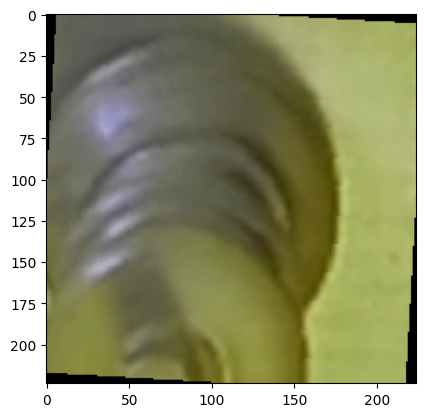

Label: 8


In [7]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1]
label = train_labels[1]
img = img.numpy().transpose((1, 2, 0))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = img * std + mean
plt.imshow(img)
plt.show()
print(f"Label: {label}")


In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [9]:

import torchvision.models as models
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
#model = models.resnet18(pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 290MB/s]


In [10]:
num_classes = 13
model.classifier[6] = nn.Linear(4096, num_classes)
#model.fc = nn.Linear(model.fc.in_features,num_classes)
#for param in model.parameters():
#  param.requires_grad = False
#model.fc.requires_grad = True

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [13]:
train_loss_history = []
test_loss_history = []
accuracy_history = []
def train_loop(dataloader, model, loss_fn, optimizer,epoch):
    size = len(dataloader.dataset)
    running_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_train_loss = running_loss / len(dataloader)
    train_loss_history.append(avg_train_loss)
    print(f"Epoch {epoch} Training Loss: {avg_train_loss:.5f}")

def test_loop(dataloader, model, loss_fn,epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_loss_history.append(test_loss)
    correct /= size
    accuracy_history.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,t)
    test_loop(test_dataloader, model, loss_fn,t)
print("Done!")
print(train_loss_history)
print(test_loss_history)
print(accuracy_history)

Epoch 1
-------------------------------
loss: 2.700095  [   64/  425]
Epoch 0 Training Loss: 2.53848
Test Error: 
 Accuracy: 13.0%, Avg loss: 2.493179 

Epoch 2
-------------------------------
loss: 2.387683  [   64/  425]
Epoch 1 Training Loss: 2.02061
Test Error: 
 Accuracy: 28.1%, Avg loss: 2.225183 

Epoch 3
-------------------------------
loss: 1.680074  [   64/  425]
Epoch 2 Training Loss: 1.49088
Test Error: 
 Accuracy: 32.2%, Avg loss: 2.006584 

Epoch 4
-------------------------------
loss: 1.351599  [   64/  425]
Epoch 3 Training Loss: 1.22766
Test Error: 
 Accuracy: 35.1%, Avg loss: 2.181231 

Epoch 5
-------------------------------
loss: 1.026106  [   64/  425]
Epoch 4 Training Loss: 1.00251
Test Error: 
 Accuracy: 31.9%, Avg loss: 2.075745 

Epoch 6
-------------------------------
loss: 0.956597  [   64/  425]
Epoch 5 Training Loss: 0.89080
Test Error: 
 Accuracy: 28.8%, Avg loss: 2.293312 

Epoch 7
-------------------------------
loss: 0.741795  [   64/  425]
Epoch 6 Trai

In [15]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

ValueError: ignored

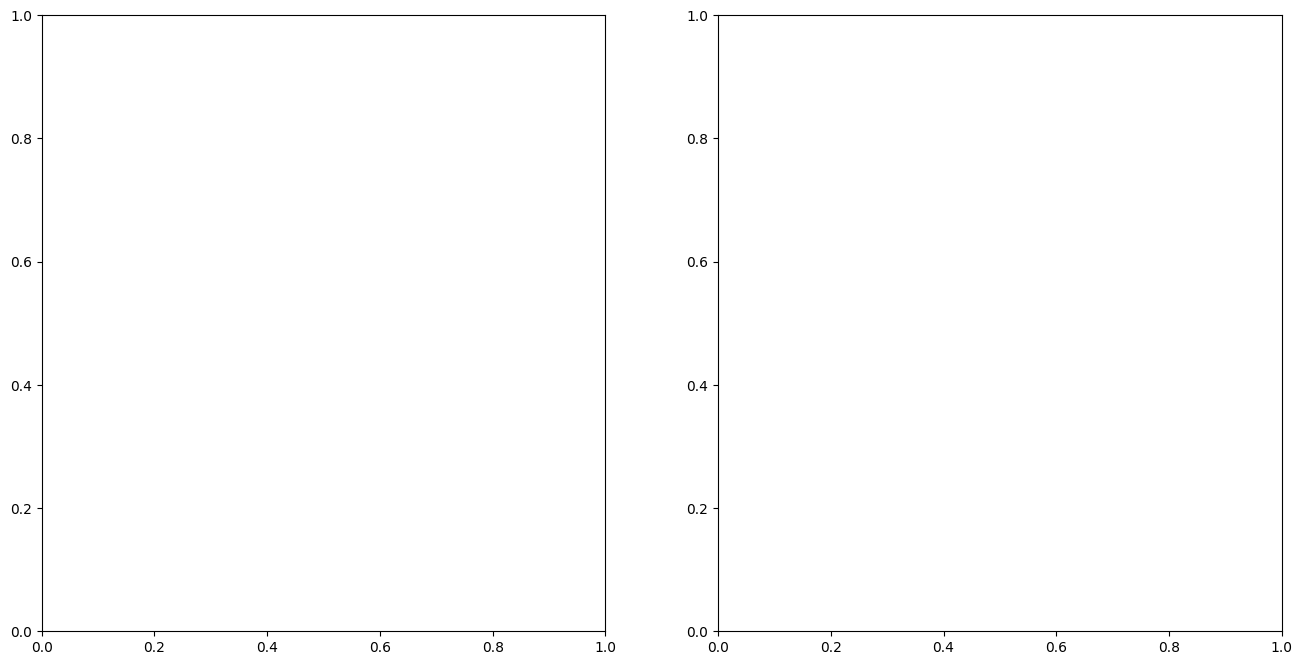

In [16]:

import matplotlib.pyplot as plt
import numpy as np
#train_loss_history = np.array([1.4240241815214572, 0.6743434712938641, 0.5251672585373339, 0.4209866442758104, 0.3665864189033923, 0.3119571837394134, 0.30811300517424295, 0.2771539046712544, 0.2658559236189593, 0.23610275902825853, 0.2107924334704876, 0.1951693702975045, 0.21788234142181667, 0.21922369463288266, 0.18860126497304958, 0.19431392686522525, 0.1905867590204529, 0.15833423294774865, 0.1622656657481971, 0.15246030631596627, 0.13884985966496574])
#test_loss_history = np.array([0.8732597927252451, 0.3952136884133021, 0.36476649592320126, 0.2637745713194211, 0.3229479094346364, 0.33497155209382373, 0.36733468373616535, 0.29535485059022903, 0.3318900515635808, 0.1894607109328111, 0.22734962155421576, 0.3755052884419759, 0.27524428566296893, 0.210154190659523, 0.20882737015684447, 0.2089658205707868, 0.4170721620321274, 0.2517162039875984, 0.22420443842808405, 0.158171276251475, 0.2644984970490138])
#accuracy_history = np.array([0.6522911051212938, 0.8544474393530997, 0.8598382749326146, 0.9137466307277629, 0.8733153638814016, 0.8652291105121294, 0.8463611859838275, 0.8652291105121294, 0.8867924528301887, 0.9299191374663073, 0.9164420485175202, 0.8706199460916442, 0.8975741239892183, 0.9191374663072777, 0.9245283018867925, 0.9299191374663073, 0.8571428571428571, 0.9272237196765498, 0.9110512129380054, 0.9326145552560647, 0.9056603773584906])
epochs = 20
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.plot(range(epochs+1),train_loss_history,label="Train Loss")
ax1.plot(range(epochs+1),test_loss_history,label="Test Loss")
ax1.set_xticks(np.arange(0,22,2))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training and Test Loss Over Epochs")
ax1.legend()

ax2.plot(range(epochs+1),accuracy_history*100,label="Accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy %")
ax2.set_yticks(np.arange(65,105,5))
ax2.set_title("Accuracy % Over Epochs")
ax2.legend()
plt.show